In [1]:
import numpy as np
import pandas as pd

from dsc2024 import datasets
from dsc2024 import handling
from dsc2024 import features

# Data Handling

In [2]:
# Parameters
sampling = None # None to use everything
real_test = True # cancel sampling!

In [3]:
%%time

if real_test:
    sampling = None
df = datasets.get_train_dataset(sampling=sampling)

dataset row:149631 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                              ^
dataset row:149639 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051300 10012KT 9999 FEW021 SCT050 28/24 Q1014=
                              ^
dataset row:149657 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                              ^
dataset row:149673 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051400 09013KT 9999 VCSH FEW021 SCT050 29/24 Q1013=
                              ^
dataset row:149678 Line 1: expected one of:

    - [\d] from METAR::datetime
    - "Z" from METAR::datetime

     1 | METAR COR SBSV 051400 09

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 72 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hora_ref                       211679 non-null  datetime64[ns]
 1   origem                         211679 non-null  object        
 2   destino                        211679 non-null  object        
 3   url_img_satelite               208741 non-null  object        
 4   prev_troca_cabeceira           211679 non-null  int64         
 5   troca_cabeceira_hora_anterior  211679 non-null  int64         
 6   espera                         211679 non-null  float64       
 7   destino_altitude               211679 non-null  int64         
 8   destino_op_diurna              149526 non-null  object        
 9   destino_op_noturna             133082 non-null  object        
 10  destino_comprime

In [5]:
# drop columns with only has null values
df.dropna(axis=1, how="all", inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 66 columns):
 #   Column                         Non-Null Count   Dtype         
---  ------                         --------------   -----         
 0   hora_ref                       211679 non-null  datetime64[ns]
 1   origem                         211679 non-null  object        
 2   destino                        211679 non-null  object        
 3   url_img_satelite               208741 non-null  object        
 4   prev_troca_cabeceira           211679 non-null  int64         
 5   troca_cabeceira_hora_anterior  211679 non-null  int64         
 6   espera                         211679 non-null  float64       
 7   destino_altitude               211679 non-null  int64         
 8   destino_op_diurna              149526 non-null  object        
 9   destino_op_noturna             133082 non-null  object        
 10  destino_comprime

/tmp/ipykernel_224193/2335175760.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(axis=1, how="all", inplace=True)


In [6]:
df = features.create_timedelta_features(df)

/home/lerax/Desktop/workspace/dsc2024/dsc2024/features.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hora_do_voo"] = df.hora_ref.apply(lambda x: x.hour)
/home/lerax/Desktop/workspace/dsc2024/dsc2024/features.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hora_classe"] = df.hora_ref.apply(lambda x: _categorize_hour(x.hour))


In [7]:
# drop non-feature datetime / image columns (to be out of baseline for feature engineering)
datetime_columns = ["hora_ref", "metaf_date_time", "metar_date_time", "url_img_satelite"]
df.drop(columns=datetime_columns, inplace=True)
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 64 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   origem                         211679 non-null  object 
 1   destino                        211679 non-null  object 
 2   prev_troca_cabeceira           211679 non-null  int64  
 3   troca_cabeceira_hora_anterior  211679 non-null  int64  
 4   espera                         211679 non-null  float64
 5   destino_altitude               211679 non-null  int64  
 6   destino_op_diurna              149526 non-null  object 
 7   destino_op_noturna             133082 non-null  object 
 8   destino_comprimento            211679 non-null  int64  
 9   destino_largura                211679 non-null  int64  
 10  destino_superficie             211679 non-null  object 
 11  destino_designacao_left        211679 n

/tmp/ipykernel_224193/4125835211.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=datetime_columns, inplace=True)


In [8]:
# bad predictor or more than >25% missing values
useless_features = [
    "metar_current_wx3",
    # "metar_skyc4",
    # "metar_skylev4",
    "metaf_current_wx2",
    # "metaf_skylev1",
    # "metaf_skylev2",
    # "metar_skylev3",
    # "metar_skylev4",
    # "metar_wind_gust",
    # "metar_skyc3",
    # "metar_skylev3",
    "hora_do_voo"
]
def drop_useless_features(features):
    features.drop(columns=useless_features, inplace=True)
    return features

drop_useless_features(df)

/tmp/ipykernel_224193/2012970137.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  features.drop(columns=useless_features, inplace=True)


,origem,destino,prev_troca_cabeceira,troca_cabeceira_hora_anterior,espera,destino_altitude,destino_op_diurna,destino_op_noturna,destino_comprimento,destino_largura,...,metaf_cloudcover,metaf_temperature,metaf_dewpoint,metaf_altimeter,metaf_current_wx1_symbol,metaf_current_wx2_symbol,metaf_current_wx3_symbol,metaf_remarks,vector,hora_classe
flightid,,,,,,,,,,,,,,,,,,,,,
504a62621cd231d6ab67e674ce538cd3,SBCF,SBFL,0,1,0.0,5,VFR / IFR - CAT I,VFR / IFR - CAT I,1320,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[-0.230078, 0.3054307, 0.059676476, -0.4976933...",madrugada
b0fd0f83644625ecc21f5261e8e5e347,SBPA,SBFL,0,1,0.0,5,VFR / IFR - CAT I,VFR / IFR - CAT I,1320,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[-0.230078, 0.3054307, 0.059676476, -0.4976933...",madrugada
1210f0ca07ddca00d09a3e02d3b100d8,SBSP,SBCF,0,0,0.0,829,NaN,NaN,3600,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[-0.230078, 0.3054307, 0.059676476, -0.4976933...",madrugada
b25032f34507cce285ee779446496568,SBGR,SBCT,0,0,0.0,911,VFR / IFR - CAT II,VFR / IFR - CAT II,2218,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[-0.230078, 0.3054307, 0.059676476, -0.4976933...",madrugada
00762a9892ecba7c66d1d87800d38cac,SBSP,SBSV,0,1,0.0,20,VFR / IFR - CAT I,NaN,1518,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[-0.230078, 0.3054307, 0.059676476, -0.4976933...",madrugada
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
0a98b5dca235756c6020ae64c1576497,SBCT,SBSP,0,0,0.0,802,VFR / IFR - CAT I,VFR / IFR - CAT I,1940,45,...,6.0,26.0,18.0,29.766223,0.0,0.0,0.0,,"[-0.091816105, 0.8501952, -1.5082136, -0.41015...",dia
000143522a56fa245543e477c74fd908,SBSP,SBRF,0,0,0.0,10,NaN,NaN,3007,45,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[-0.091816105, 0.8501952, -1.5082136, -0.41015...",dia
1067786192e3ee6942524b8bf3b9e876,SBSP,SBRJ,0,0,0.0,3,VFR / IFR Não Precisão,VFR / IFR Não Precisão,1260,30,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,"[-0.091816105, 0.8501952, -1.5082136, -0.41015...",dia


In [9]:
X = df.drop("espera", axis=1)
y = df.espera.astype(int)

In [10]:
# probability of having espera P(espera=1) = 1.74%, extremely unbanlaced 
y.value_counts() / y.count()

espera
0    0.982587
1    0.017413
Name: count, dtype: float64

In [11]:
cat_features = X.select_dtypes(include=['object']).columns.tolist()
embedding_features = ["vector"]
[cat_features.remove(x) for x in embedding_features]
cat_features,embedding_features

(['origem',
  'destino',
  'destino_op_diurna',
  'destino_op_noturna',
  'destino_superficie',
  'destino_designacao_left',
  'destino_designacao_right',
  'metar_station_id',
  'metar_current_wx1',
  'metar_current_wx2',
  'metar_skyc1',
  'metar_skyc2',
  'metar_skyc3',
  'metar_skyc4',
  'metar_remarks',
  'metaf_station_id',
  'metaf_current_wx1',
  'metaf_skyc1',
  'metaf_skyc2',
  'metaf_remarks',
  'hora_classe'],
 ['vector'])

# Data Imputation

In [12]:
# Fill categorical features with unknown class (a new category)
# numerical features will be filled with min-value catboost default strategy
cat_features_fill_map = {f: "UNKNOWN" for f in cat_features}
X.fillna(cat_features_fill_map, inplace=True)

In [13]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 211679 entries, 504a62621cd231d6ab67e674ce538cd3 to c962a2267ae4fe0afa4c3542ebdbd403
Data columns (total 60 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   origem                         211679 non-null  object 
 1   destino                        211679 non-null  object 
 2   prev_troca_cabeceira           211679 non-null  int64  
 3   troca_cabeceira_hora_anterior  211679 non-null  int64  
 4   destino_altitude               211679 non-null  int64  
 5   destino_op_diurna              211679 non-null  object 
 6   destino_op_noturna             211679 non-null  object 
 7   destino_comprimento            211679 non-null  int64  
 8   destino_largura                211679 non-null  int64  
 9   destino_superficie             211679 non-null  object 
 10  destino_designacao_left        211679 non-null  object 
 11  destino_designacao_right       211679 n

# Data Split Train/Test

In [14]:
from sklearn.model_selection import train_test_split
random_state = 42
X_base_train, X_test, y_base_train, y_test = train_test_split(X, y, test_size=0.20, random_state=random_state)
X_train, X_eval, y_train, y_eval = train_test_split(X_base_train, y_base_train, test_size=1/8, random_state=random_state)

# real test -> to submit to kaggle, replace X_test from unlabelled samples and resplit train/eval dataset
# WARNING: in this mode, metrics report and confusion matrix are not reliable, since it trained with all data. So they are not show.
if real_test:
    # TODO: move this data handling to be by default at datasets.get_public_dataset()

    # data handling
    df_real_test = datasets.get_test_dataset()    
    df_real_test.dropna(axis=1, how="all", inplace=True)
    df_reat_test = features.create_timedelta_features(df_real_test)
    df_real_test.drop(columns=datetime_columns, inplace=True)
    drop_useless_features(df_real_test)
    X_test = df_real_test
    X_test.fillna(cat_features_fill_map, inplace=True)

    # split
    _, X_eval, _, y_eval = train_test_split(X, y, test_size=0.20, random_state=random_state)

/tmp/ipykernel_224193/4207635779.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_real_test.dropna(axis=1, how="all", inplace=True)
/home/lerax/Desktop/workspace/dsc2024/dsc2024/features.py:189: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["hora_do_voo"] = df.hora_ref.apply(lambda x: x.hour)
/home/lerax/Desktop/workspace/dsc2024/dsc2024/features.py:190: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.

# Add graph Features

In [15]:
from dsc2024 import features
X_train = features.generate_graph_features(X_train)
X_test = features.graph_features_testdata(X_test, X_train)
X_eval = features.graph_features_testdata(X_eval, X_train)

/home/lerax/Desktop/workspace/dsc2024/dsc2024/features.py:126: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[_, "betwenness"] = train_measures[edge_key]["betwenness"]
/home/lerax/Desktop/workspace/dsc2024/dsc2024/features.py:127: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_test.loc[_, "flow_betweenness_topo"] = train_measures[edge_key]["flow_betweenness_topo"]
/home/lerax/Desktop/workspace/dsc2024/dsc2024/features.py:128: SettingWithCopyWarning: 
A value is trying to be set on a copy of a s

In [16]:
# Imputation by mean

# from sklearn.impute import SimpleImputer

# numeric_columns = X_train.select_dtypes(include='number').columns
# imputer = SimpleImputer(strategy="most_frequent").fit(X_train[numeric_columns])
# datasets_to_imput = [X_train, X_test, X_eval]
# for dataset in datasets_to_imput:
#     dataset_subset_imputed = imputer.transform(dataset[numeric_columns])
#     dataset[numeric_columns] = pd.DataFrame(dataset_subset_imputed, index=dataset.index, columns=numeric_columns)


In [17]:
X_train.describe().T

,count,mean,std,min,25%,50%,75%,max
prev_troca_cabeceira,148175.0,0.315343,0.464654,0.000000,0.000000,0.000000,1.000000,1.000000
troca_cabeceira_hora_anterior,148175.0,0.225504,0.417915,0.000000,0.000000,0.000000,0.000000,1.000000
destino_altitude,148175.0,510.954419,413.305505,3.000000,9.000000,750.000000,829.000000,1066.000000
destino_comprimento,148175.0,2581.410150,916.831118,1260.000000,1940.000000,3007.000000,3240.000000,4000.000000
destino_largura,148175.0,42.871301,5.234435,30.000000,45.000000,45.000000,45.000000,45.000000
metar_latitude,147048.0,-21.577119,5.244838,-30.000000,-23.620000,-23.000000,-19.630000,-8.130000
metar_longitude,147048.0,-45.421172,3.889899,-51.170000,-47.920000,-46.630000,-43.170000,-34.920000
metar_elevation,147048.0,511.457796,413.143588,3.000000,5.000000,750.000000,828.000000,1061.000000
metar_wind_direction,139252.0,158.652730,98.158495,0.000000,90.000000,140.000000,210.000000,360.000000
metar_wind_speed,147044.0,7.044490,3.786275,0.000000,4.000000,7.000000,9.000000,35.000000


In [18]:
# computer class weights
from sklearn.utils.class_weight import compute_class_weight
 
classes = np.unique(y_train)
class_weights = compute_class_weight(class_weight='balanced', classes=classes, y=y_train)
class_0 = class_weights[0]
class_weights = class_weights / class_0

# Training model

In [20]:
%%time
from catboost import CatBoostClassifier, Pool

train_data = Pool(
   data=X_train,
   label=y_train,
   cat_features=cat_features,
   embedding_features=embedding_features
)

# metric = "TotalF1:average=Macro;use_weights=False"
eval_metric = "Logloss"
metric = "F1:use_weights=false"
# eval_metric = metric # this may cause overfit with early_stopping_rounds enabled
model = CatBoostClassifier(
    iterations=3000,  
    early_stopping_rounds=70,  # Number of iterations to wait for improvement
    eval_metric=eval_metric,  # Metric to use for early stopping
    cat_features=cat_features,
    embedding_features=embedding_features,
    custom_loss=[metric],
    verbose=50,  # Print information every n iterations,
    random_seed=random_state,
    bagging_temperature=10,
    use_best_model=True,
    depth=16, # Maximum number of trees depth (you can adjust this)
    learning_rate=0.004,
    subsample=0.8,
    # class_weights=class_weights, # class weights, because dataset is unbalanced
    auto_class_weights="Balanced",
)


model.fit(train_data, eval_set=(X_eval, y_eval), plot=True)

MetricVisualizer(layout=Layout(align_self='stretch', height='500px'))

0:	learn: 0.6904085	test: 0.6913607	best: 0.6913607 (0)	total: 3.92s	remaining: 3h 15m 58s
50:	learn: 0.6033654	test: 0.6356653	best: 0.6356653 (50)	total: 2m 30s	remaining: 2h 24m 46s
100:	learn: 0.5379240	test: 0.5993462	best: 0.5993462 (100)	total: 5m 2s	remaining: 2h 24m 45s
150:	learn: 0.4931699	test: 0.5779995	best: 0.5779995 (150)	total: 7m 25s	remaining: 2h 19m 59s
200:	learn: 0.4501442	test: 0.5662682	best: 0.5662682 (200)	total: 10m 16s	remaining: 2h 23m 5s
250:	learn: 0.4172317	test: 0.5584327	best: 0.5584105 (249)	total: 12m 57s	remaining: 2h 21m 51s
300:	learn: 0.3913461	test: 0.5541711	best: 0.5541285 (298)	total: 15m 30s	remaining: 2h 19m 2s
350:	learn: 0.3707646	test: 0.5523973	best: 0.5523973 (350)	total: 17m 52s	remaining: 2h 14m 55s
400:	learn: 0.3563064	test: 0.5524128	best: 0.5519721 (392)	total: 19m 49s	remaining: 2h 8m 29s
450:	learn: 0.3415004	test: 0.5529033	best: 0.5519721 (392)	total: 22m	remaining: 2h 4m 22s
Stopped by overfitting detector  (70 iterations wa

In [21]:
y_pred = model.predict(X_test)

# Model evaluation

In [22]:
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import f1_score

if not real_test:
    report = classification_report(y_test, y_pred)
    f1_score_class1 = f1_score(y_test, y_pred, average=None)
    print(f"Classification Report: F1[class=1] = {round(f1_score_class1[1], 3)}")
    print(report)
    
    # Print confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    print("Confusion Matrix:")
    print(cm)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.show()

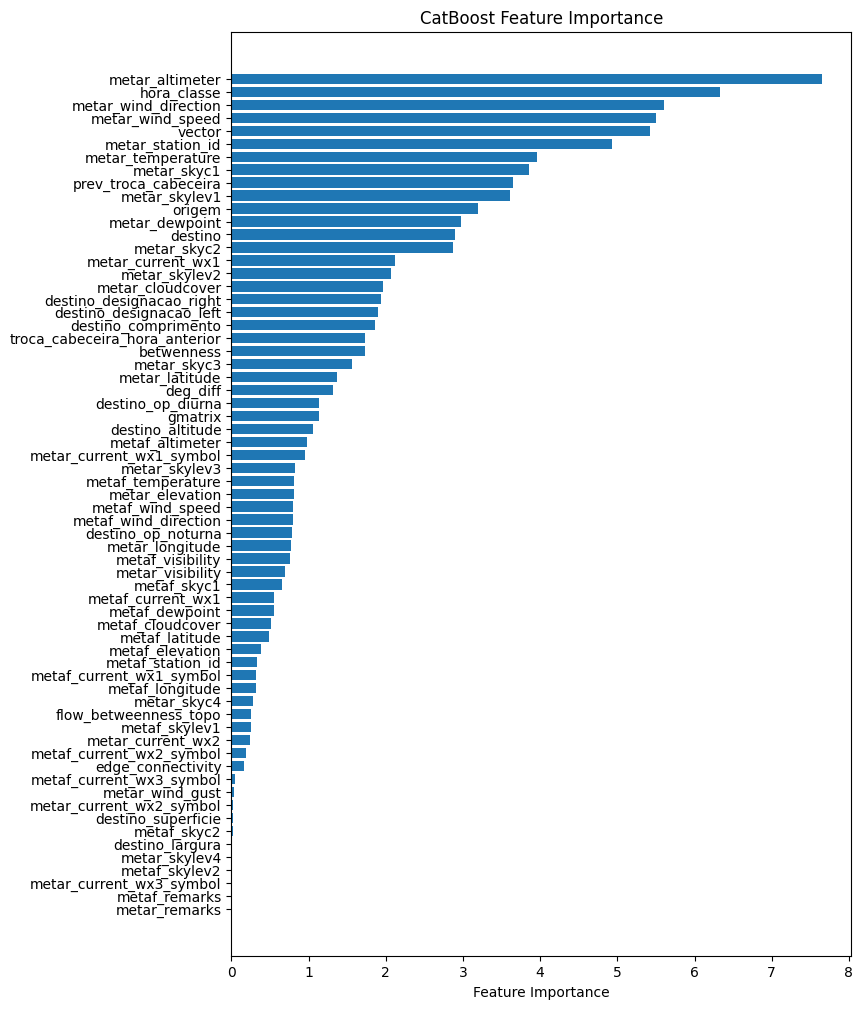

In [23]:
# plot feature importance
feature_importance = model.get_feature_importance(type='FeatureImportance')
feature_names = model.feature_names_
sorted_idx = feature_importance.argsort()

plt.figure(figsize=(8, 12))
plt.barh(range(len(sorted_idx)), feature_importance[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel('Feature Importance')
plt.title('CatBoost Feature Importance')
plt.show()

# Save prediction


In [24]:
if real_test:
    y_pred_series = pd.Series(y_pred, index=X_test.index, name="espera")
    y_pred_series.to_csv(datasets.datasets_dir / "catboost_submit.csv")

In [25]:
y_pred_series.count()

90720